# Explore
# Matched DMV Crash and Hospital data (MV104/SPARCS)

data provided by dohmh

### Variables given - from crash data
date/time of crash
* date - date of crash

person injured
* f_per_age
* f_per_sex - male, female
* f_per_role (f_per_role_doh) - driver, passenger, pedestrian, bicyclist, motorcyclist (dohmh was able to extract motorcylists), unknown
* f_per_ejected - ejected, not ejected, unknown
* f_per_loc - at intersection, not at intersection, unknown (majority are unknown)

injury information
* f_inj_status_num - 1-6, unknown
* f_inj_status - conscious stated, not conscious states, death
* f_inj_type - 14 types, unknown
* f_inj_loc - 12 locations, unknown

road information
* f_road_light - 5 types, unknown
* f_road_surf_bi - dry, not dry unknown
* f_road_surf - dry, flooded, muddy, slush, snow/ice, wet, unknown (almost all dry)
* f_road_weather - clear, cloudy, rain, snow, sleet, fog, other, unknown
* f_road_control - none, traffic signal, stop sign, other, unknown

vehicle information
* f_act_veh - what the vehicle the person was in was doing - need to narrow donw
* f_veh - car, suburban, pickup, van, truck, pedestrian, bicyclist, unknown
* f_veh_doh - car/van/pickup, truck, taxi, bus, other(bike, motorcycle, ped)
* f_oveh_doh - same as above. but with two more unknown vars 6 and 7


In [1]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import databuild as db
import sys
sys.path.insert(0,'/home/deena/Documents/data_munge/ModaCode/')
import moda

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()
# pedestrians, bicyclists, single vehicle
ped, twoVeh = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()
# included biss data from linked (dropping anything not in linked)
ped = db.mergeBiss(ped,linked)
#format and categorize variables
ped = db.formatVars(ped)

print 'pedestrians in linked crashes',ped.shape


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


full crash table (522108, 26)
full person table (1502797, 22)
full vehicle table (1092922, 20)
two veh (651501, 75)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,9,20,25,35,48,54,58,63,65,85,89,102,126,128,129,138) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pedestrians/bicyclists (police reported) (single vehicle) (95292, 80)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
pedestrians in linked crashes (17624, 105)


In [3]:
crash.date.min(),crash.date.max()

(Timestamp('2007-01-01 00:00:00'), Timestamp('2013-12-31 00:00:00'))

In [19]:
# police reported crashes
crashPR = crash[crash.POL_REPT=='Y']
indPR = ind[ind.CS_ID.isin(crashPR.CS_ID)&(~ind.INJT_ID.isin(['16','17','18']))]
crashPR = crashPR[crashPR.CS_ID.isin(indPR.CS_ID)]

print crash.shape
print crashPR.shape

(522108, 26)
(371958, 26)


## Police Reported Crashes - number per day

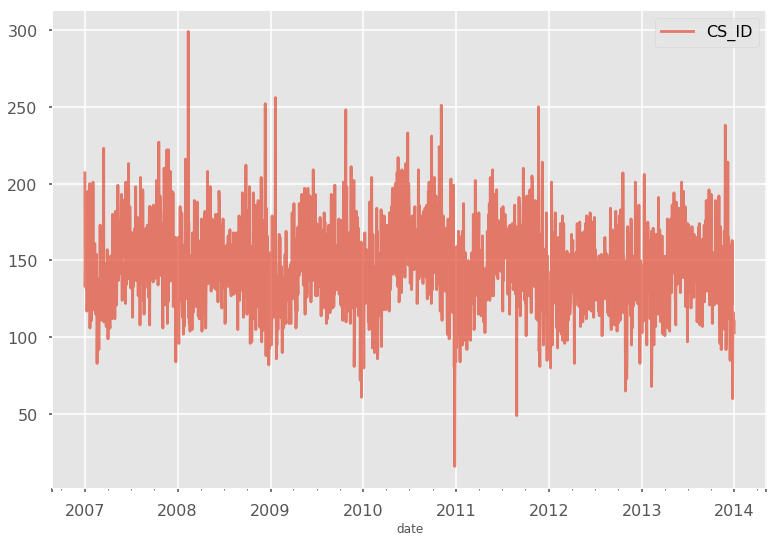

In [35]:
# police reported crashes
crashPR.groupby('date').count()[['CS_ID']].plot(alpha=.7)

## People involved in police reported crashes
* by role
* by injury severity (KABCO)

In [22]:
# format the variables for easier analysis
base = indPR.merge(crash.drop(['RDSYST_ID'],axis=1),
                      how='left',on='CS_ID')
base = db.formatVars(base)


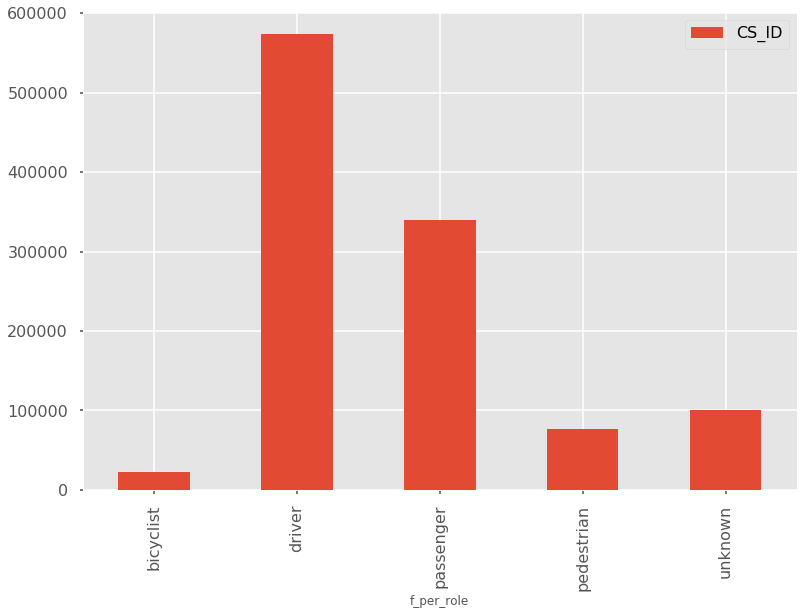

In [38]:
base.groupby(base.f_per_role).count()[['CS_ID']].plot(kind='bar')

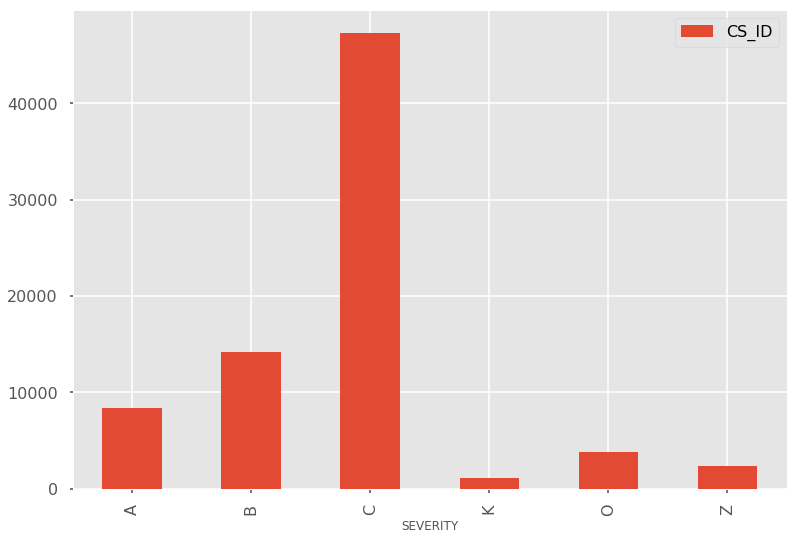

In [37]:
base[base.f_per_role=='pedestrian'].groupby(base.SEVERITY).count()[['CS_ID']].plot(kind='bar')

## Severely injured  (K,A) people 
* per day
* per year

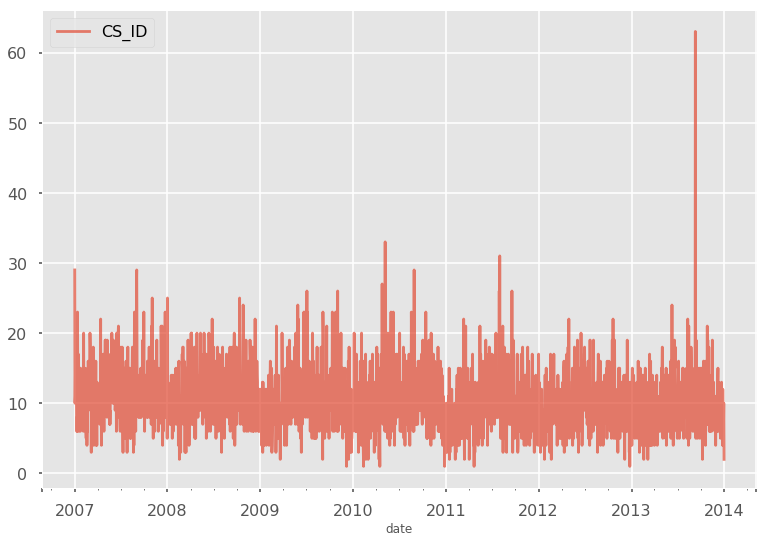

In [31]:
# number of severely injured people per day
sevInjPer = base[base.SEVERITY.isin(['K','A'])]
sevInjPer.groupby('date').count()[['CS_ID']].plot(alpha=.7)

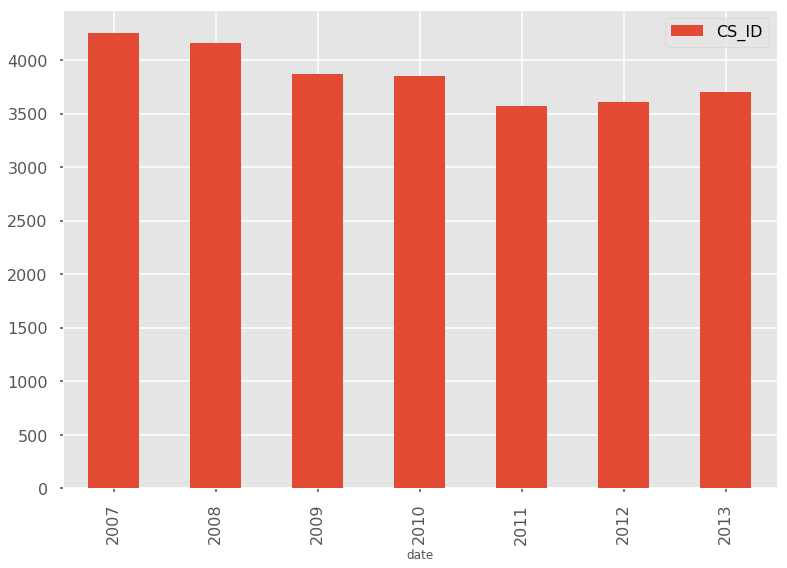

In [39]:
sevInjPer.groupby(sevInjPer.date.dt.year).count()[['CS_ID']].plot(kind='bar')

## Severely injured Pedestrians
* per day
* per year

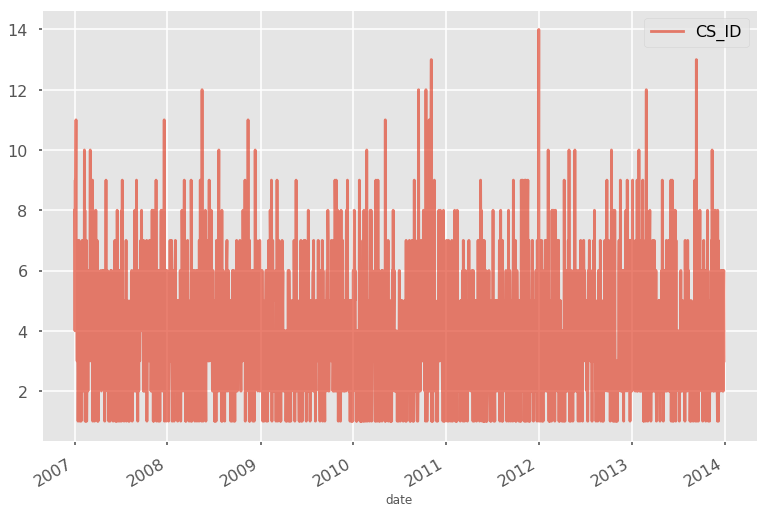

In [32]:
# number of severely injured pedestrians per day
sevInjPed = base[(base.SEVERITY.isin(['K','A']))&(base.f_per_role=='pedestrian')]
sevInjPed.groupby('date').count()[['CS_ID']].plot(alpha=.7)

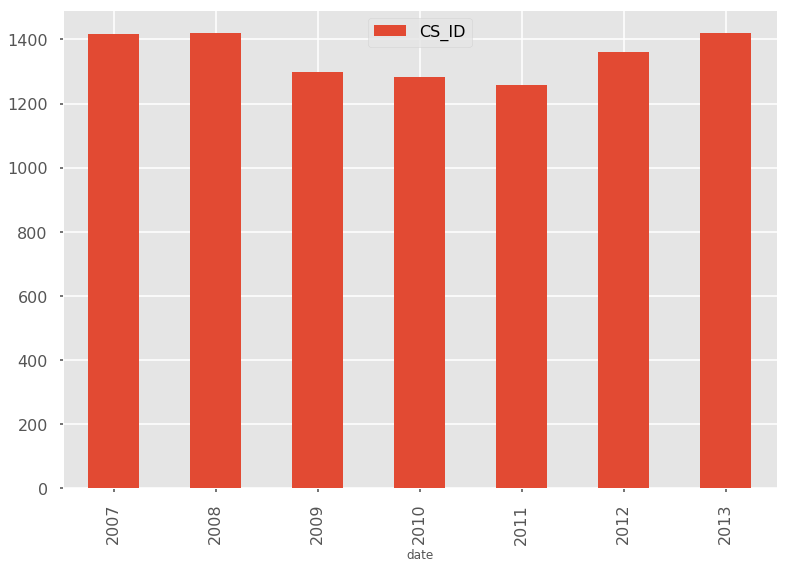

In [34]:
# number of severely injured pedestrians per year
sevInjPed.groupby(sevInjPed.date.dt.year).count()[['CS_ID']].plot(kind='bar')

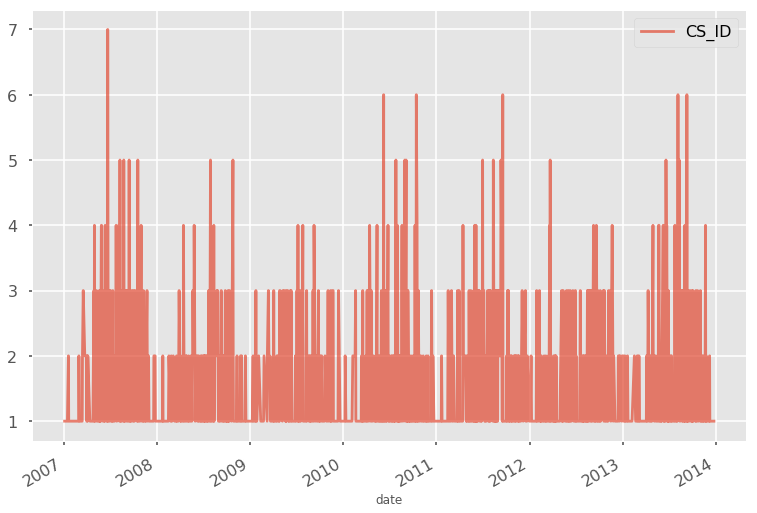

In [41]:
# number of severely injured bicyclists per day
sevInjBic = base[(base.SEVERITY.isin(['K','A']))&(base.f_per_role=='bicyclist')]
sevInjBic.groupby('date').count()[['CS_ID']].plot(alpha=.7)

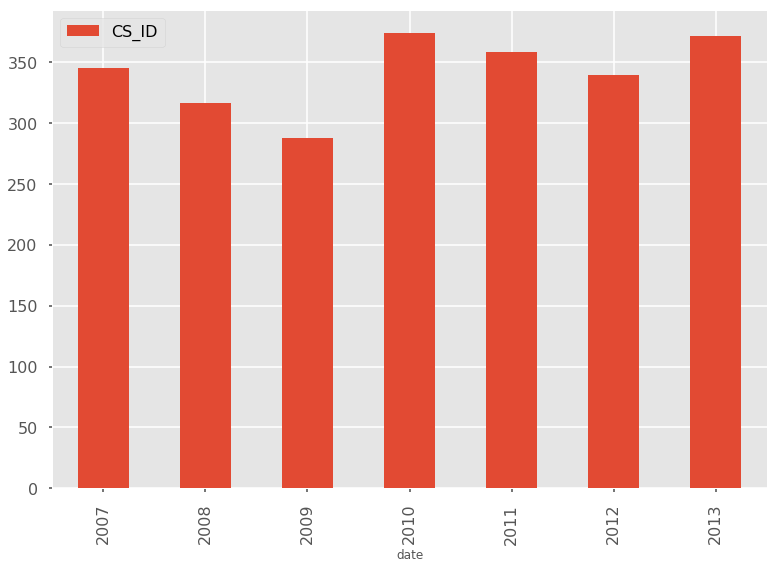

In [42]:
sevInjBic.groupby(sevInjBic.date.dt.year).count()[['CS_ID']].plot(kind='bar')

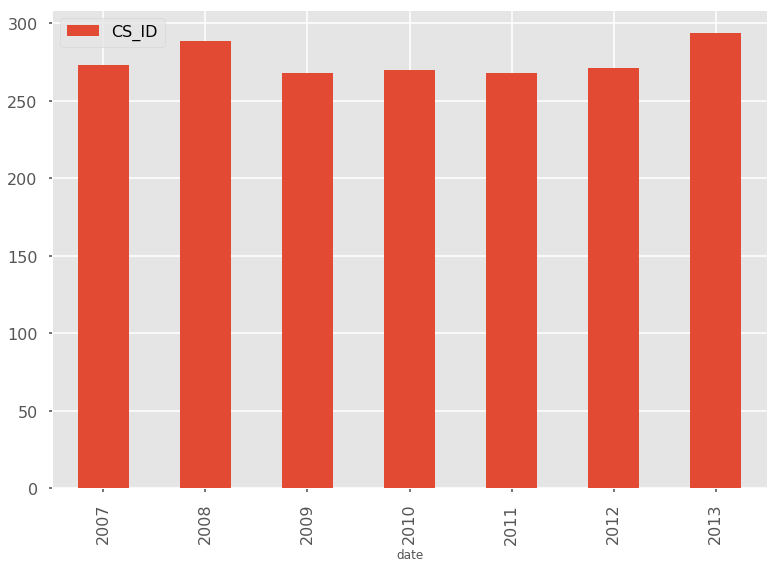

In [45]:
# number of fatalities per day
fatal = base[base.SEVERITY.isin(['K'])]
fatal.groupby(fatal.date.dt.year).count()[['CS_ID']].plot(kind='bar')

In [46]:
print 'crashes per year',crashPR.shape[0]/7

crashes per year 53136


In [51]:
aInjury = base[base.SEVERITY.isin(['A'])].CS_ID

print 'people with A injuries per year',crash[(crash.CS_ID.isin(aInjury))].shape[0]/7

people with A injuries per year 3133


In [53]:
kabcInjury = base[base.SEVERITY.isin(['K','A','B','C'])].CS_ID

print 'people with K, A,B, or C injuries per year',crash[(crash.CS_ID.isin(kabcInjury))].shape[0]/7

people with K, A,B, or C injuries per year 38959


In [54]:
kInjury = base[base.SEVERITY.isin(['K'])].CS_ID

print 'fatalities per year',crash[(crash.CS_ID.isin(kInjury))].shape[0]/7

fatalities per year 263


In [18]:
event = {
    1:'Other Motor Vehicle, Collision With',
    2:'Pedestrian, Collision With',
    3:'Bicyclist, Collision With'}

linked['event'] = linked.EVNTT_ID.astype(int).map(event)

linked.fillna('other object').groupby(['event']).count()[['CI_ID']]

,CI_ID
event,
"Bicyclist, Collision With",3738
"Other Motor Vehicle, Collision With",47472
"Pedestrian, Collision With",14785
other object,3662


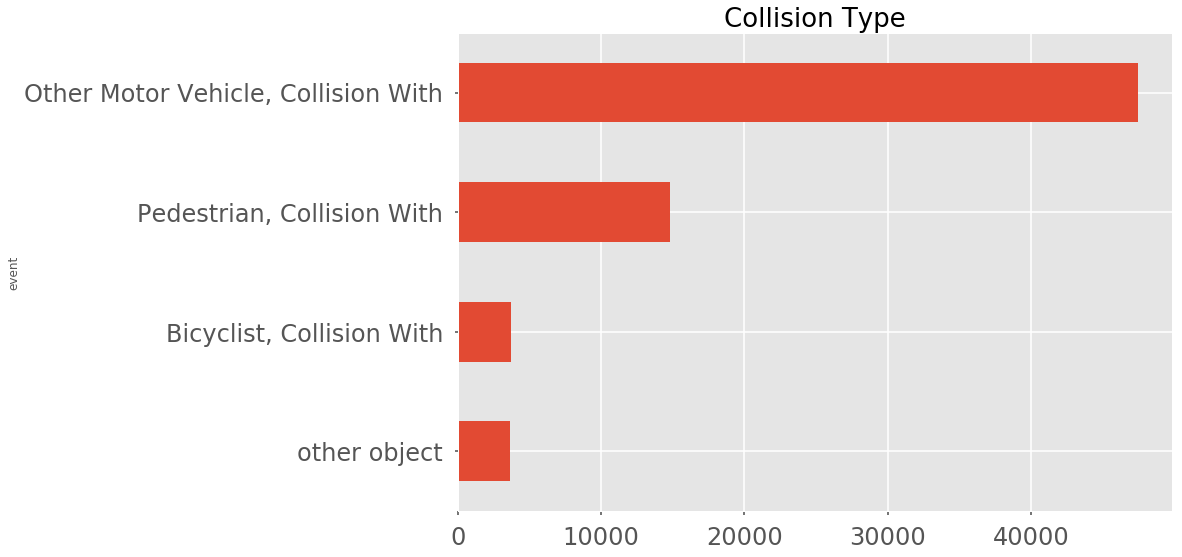

In [22]:
linked.fillna('other object').groupby(['event']).count()[['CI_ID']]\
.sort_values('CI_ID').plot(kind='barh',legend=False,fontsize=24)

plt.title('Collision Type',fontsize=26)

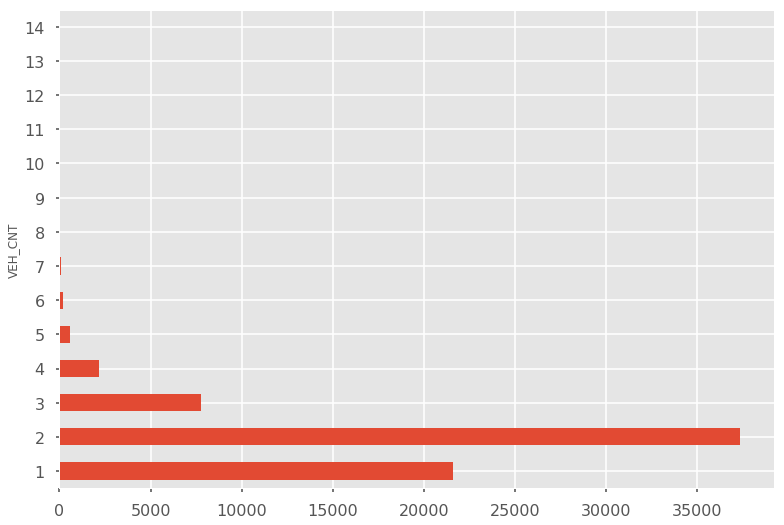

In [23]:
linked.groupby(linked.VEH_CNT.astype(int)).count()[['CI_ID']].plot(kind='barh',
                                                                   legend=False,
                                                                   )

none is unknown vehicle - I'm guessing these are hit and runs? or maybe the cop doesn't always record the vehicle and driver info?

In [55]:
ped[ped.CI_SEX_CDE_driver=='unknown'].groupby(ped.f_veh_other_vin).count()[['CI_ID']]

,CI_ID
f_veh_other_vin,
Bus,1
Car,340
Minivan,8
Pickup,3
SUV,88
Truck,4
Van,35
none,3042


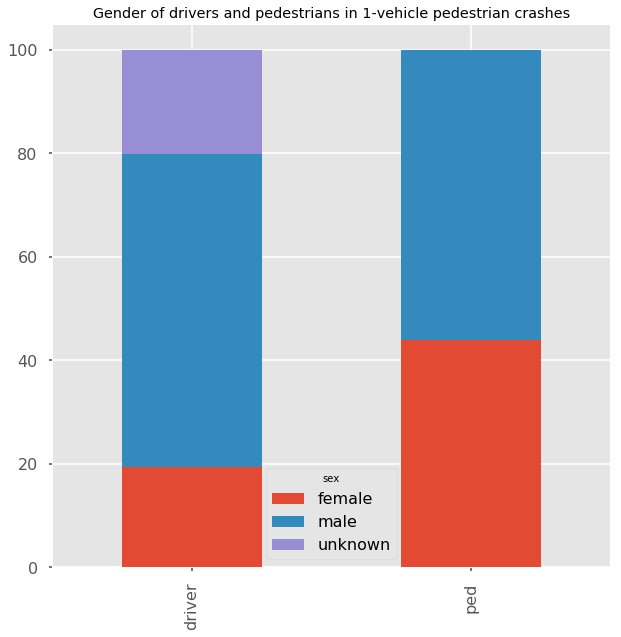

In [30]:
title = 'Gender of drivers and pedestrians in 1-vehicle pedestrian crashes'
pedSexCount = ped.groupby('f_per_sex').count()[['CI_ID']]/ped.shape[0]*100
pedSexCount.columns=['ped']
pedSexCount.index.name = 'sex'

driverSexCount = ped.groupby('f_driver_sex').count()[['CI_ID']]/ped.shape[0]*100
driverSexCount.columns = ['driver']
driverSexCount.index.name = 'sex'
driverSexCount.join(pedSexCount).T.plot(kind='bar',
                                        stacked=True,
                                        figsize=(10,10),title=title)

In [31]:
driverSexCount.join(pedSexCount)#.T.plot(kind='bar',stacked=True,figsize=(10,6))

,driver,ped
sex,,
female,19.428053,43.894689
male,60.485701,56.105311
unknown,20.086246,NaN


In [45]:
twoVeh.groupby('f_per_sex').count()[['CI_ID']]/twoVeh.shape[0]*100

,CI_ID
f_per_sex,
female,47.213266
male,52.786734


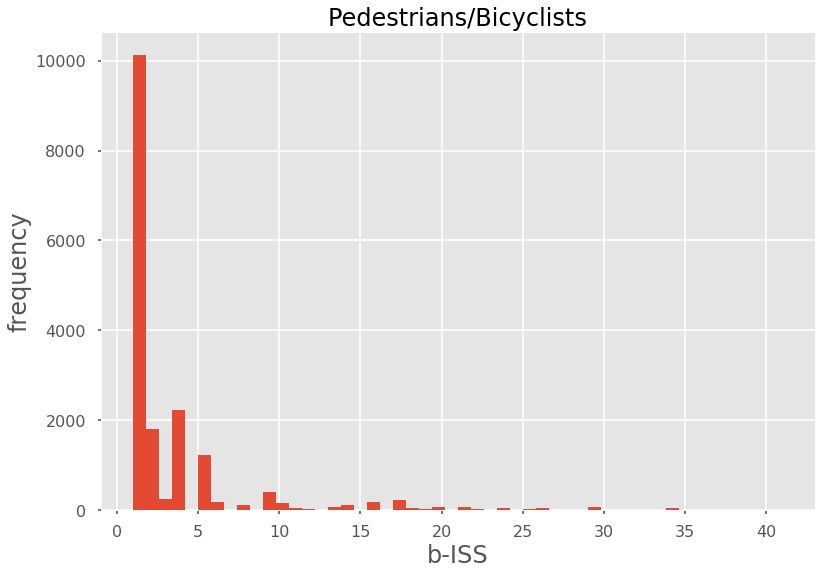

In [32]:
ped.hosp_biss.hist(bins=50)
plt.ylabel('frequency',fontsize=24)
plt.xlabel('b-ISS',fontsize=24)
plt.title('Pedestrians/Bicyclists',fontsize=24)

In [33]:
ped.shape

(17624, 103)

In [34]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,15916
True,1708


In [35]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,16725
True,899


In [36]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.903087
True,0.096913


In [37]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.94899
True,0.05101


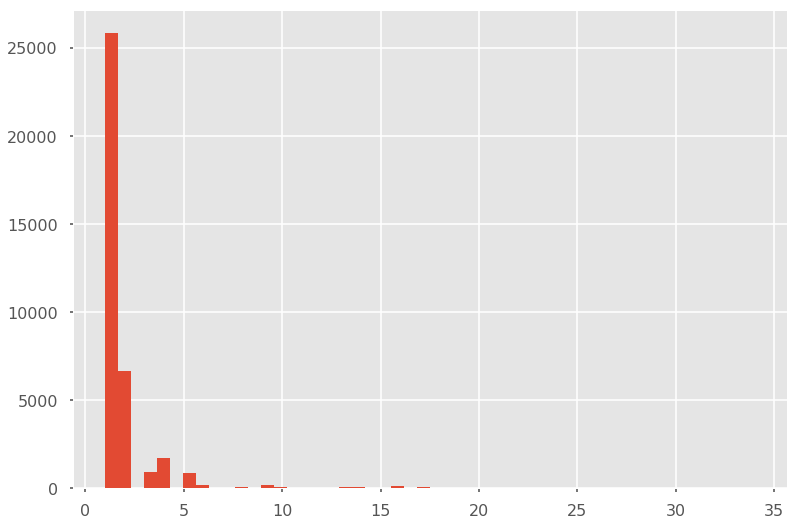

In [38]:
twoVeh.hosp_biss.hist(bins=50)

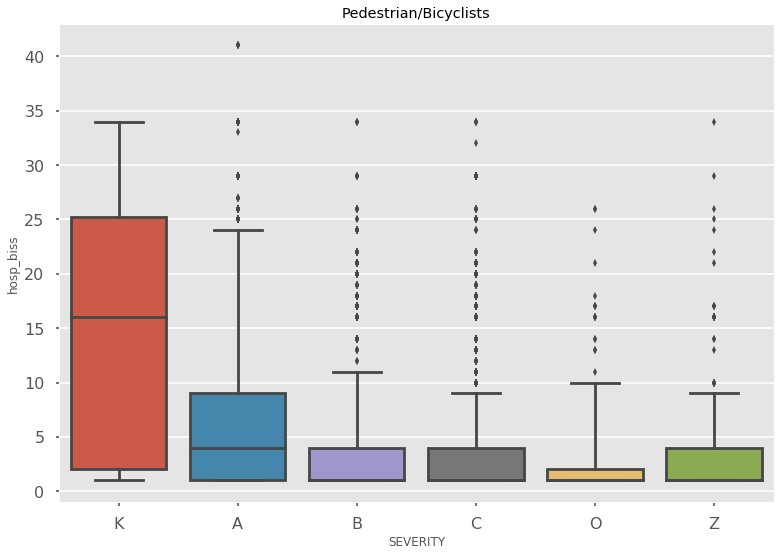

In [39]:
import seaborn as sns

sns.boxplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'], whis=[5,95]
           ).set_title('Pedestrian/Bicyclists')

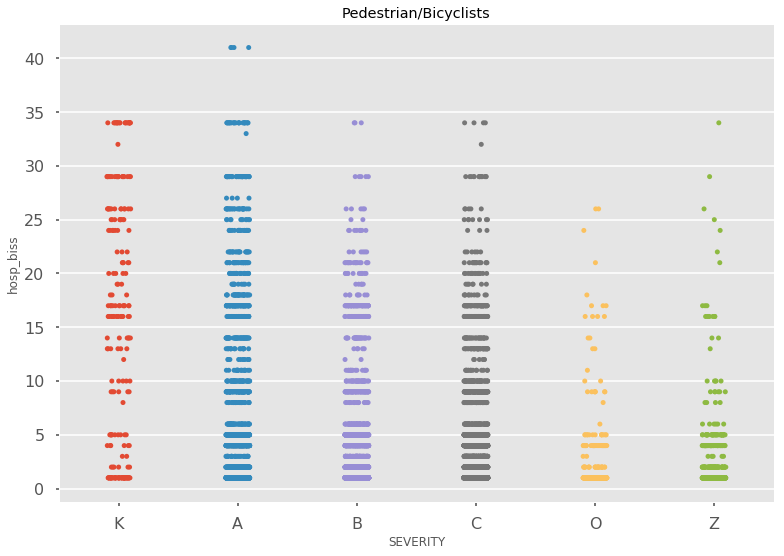

In [47]:
sns.stripplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'],jitter=True
           ).set_title('Pedestrian/Bicyclists')

In [48]:
ped.groupby('SEVERITY').count()[['CI_ID']]

,CI_ID
SEVERITY,
A,2205
B,3890
C,10452
K,220
O,326
Z,531


In [53]:
ped['kabco'] = ped[ped.SEVERITY.isin(['B','C','O'])].SEVERITY
ped.loc[ped.SEVERITY.isin(['K','A']),'kabco']='K/A'
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


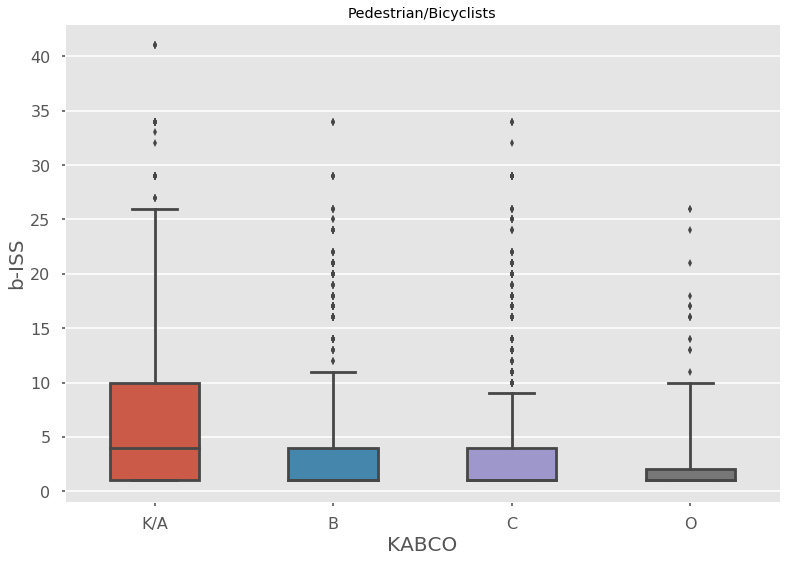

In [63]:
sns.boxplot(x='kabco',y='hosp_biss',
            data=ped,order=['K/A','B','C','O'], whis=[5,95],width=.5
           ).set_title('Pedestrian/Bicyclists')
plt.ylabel('b-ISS',fontsize=20)
plt.xlabel('KABCO',fontsize=20)

In [64]:
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


In [70]:
ct = pd.crosstab(ped.kabco=='K/A',ped.hosp_biss>8)
ct

hosp_biss,False,True
kabco,,
False,14240,959
True,1676,749


In [71]:
ped.shape[0]

17624

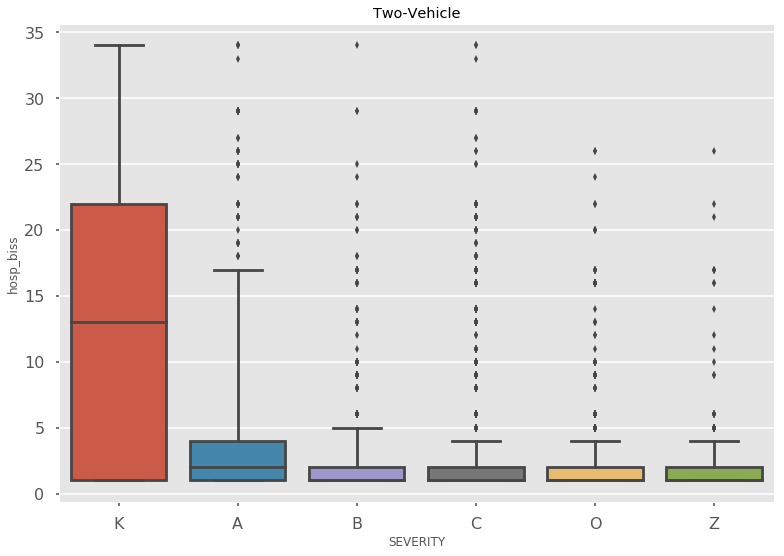

In [40]:
sns.boxplot(x='SEVERITY',y='hosp_biss',
            data=twoVeh,order=['K','A','B','C','O','Z'], whis=[5,95],
           ).set_title('Two-Vehicle')